# HABSlib 103

In the [previous lesson](notebooks/HABSlib_102.ipynb) we learned how to analyse data in a pipeline.     
In this third notebook, you will learn how to upload your data and perform a piped analysis.

**Note 1**: in this rump-up phase, your developer account allows you to upload only up to 1GB of data.    
**Note 2**: for now, we only support upload of [European Data Format](https://www.edfplus.info/)-ed files.
    
Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
hb.handshake(base_url="http://135.237.144.125", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.35

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Upload your data


In [3]:
from datetime import datetime
from scipy import signal

session_id = hb.send_file(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d'), 
    edf_file=r"test_data.edf", 
    ch_nrs=[0,1,2,3], 
    session_type="Upload data", 
    tags=['edf', 'file']
)

print("this session:", session_id)

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '08/12/2009, 16:15:00', 'session_type': 'Upload data', 'session_tags': ['edf', 'file']}
Metadata validation successful!
Session successfully created.
629760 total bytes will be sent into 3 chunks of 167657 bytes
...this session: 669a834dcc485c74bb9511b4


## Check your data
Now copy the session_id of the session you just created and paste it 

In [4]:
import numpy as np

results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id='669a834dcc485c74bb9511b4')
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(4, 19680)
[[-20. -30. -24. ...  -1.  -8.  -3.]
 [ -9. -23. -15. ...   5.  -4.  13.]
 [-18. -34. -24. ...  52.  34.  45.]
 [  1. -14.  -4. ...  27.  13.  21.]]


### plot it

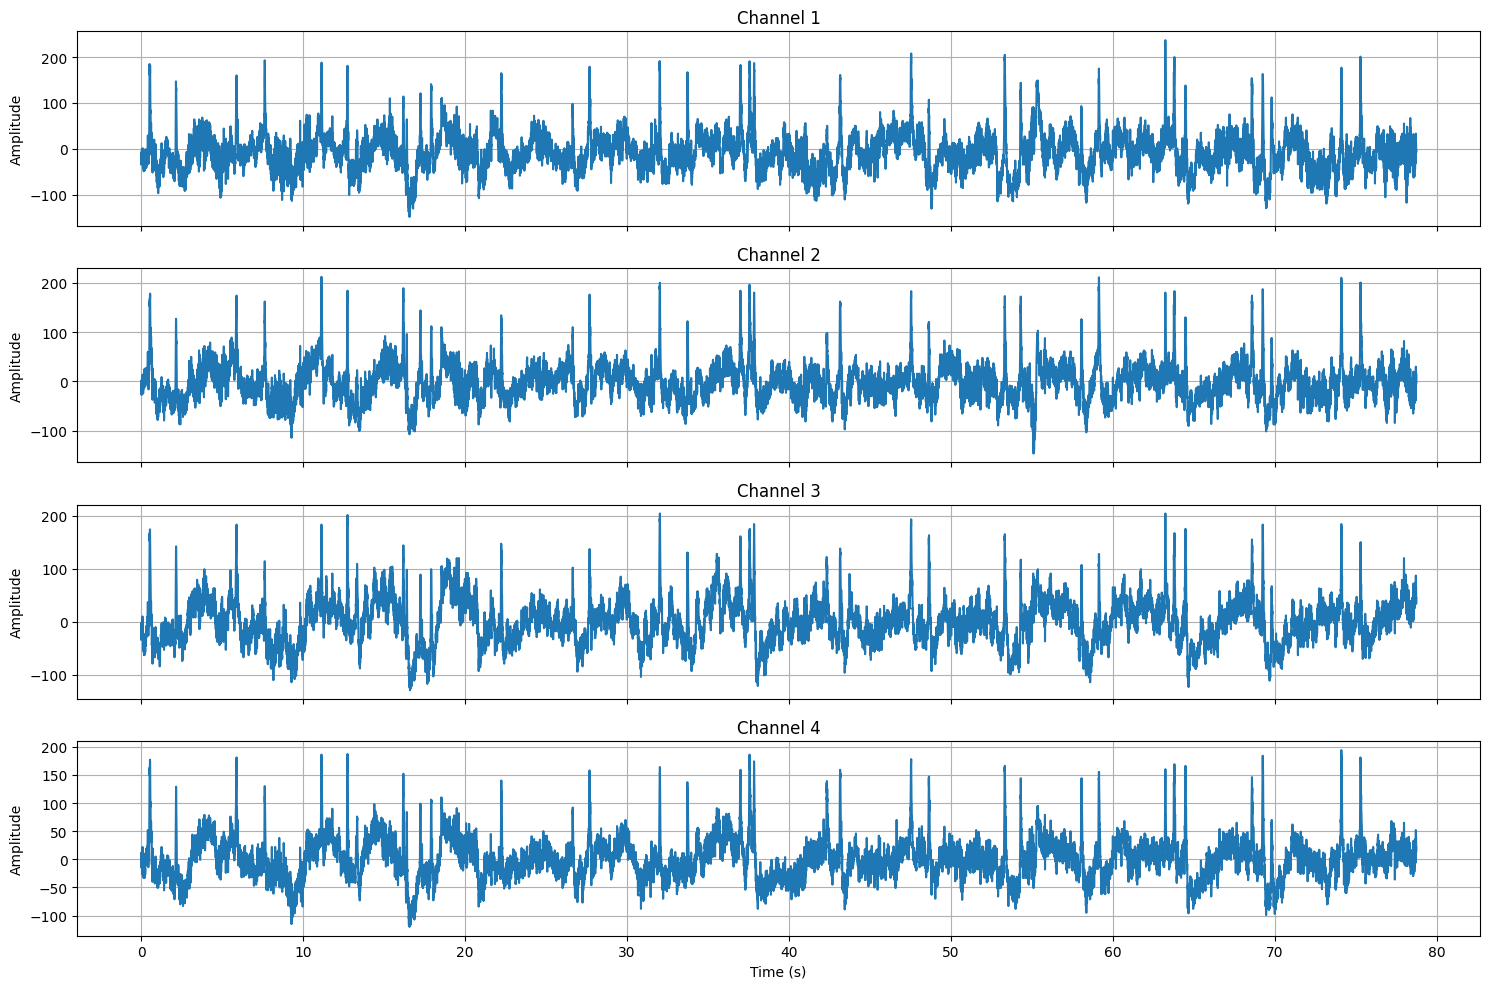

In [7]:
import matplotlib.pyplot as plt

samples_per_second = 250
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

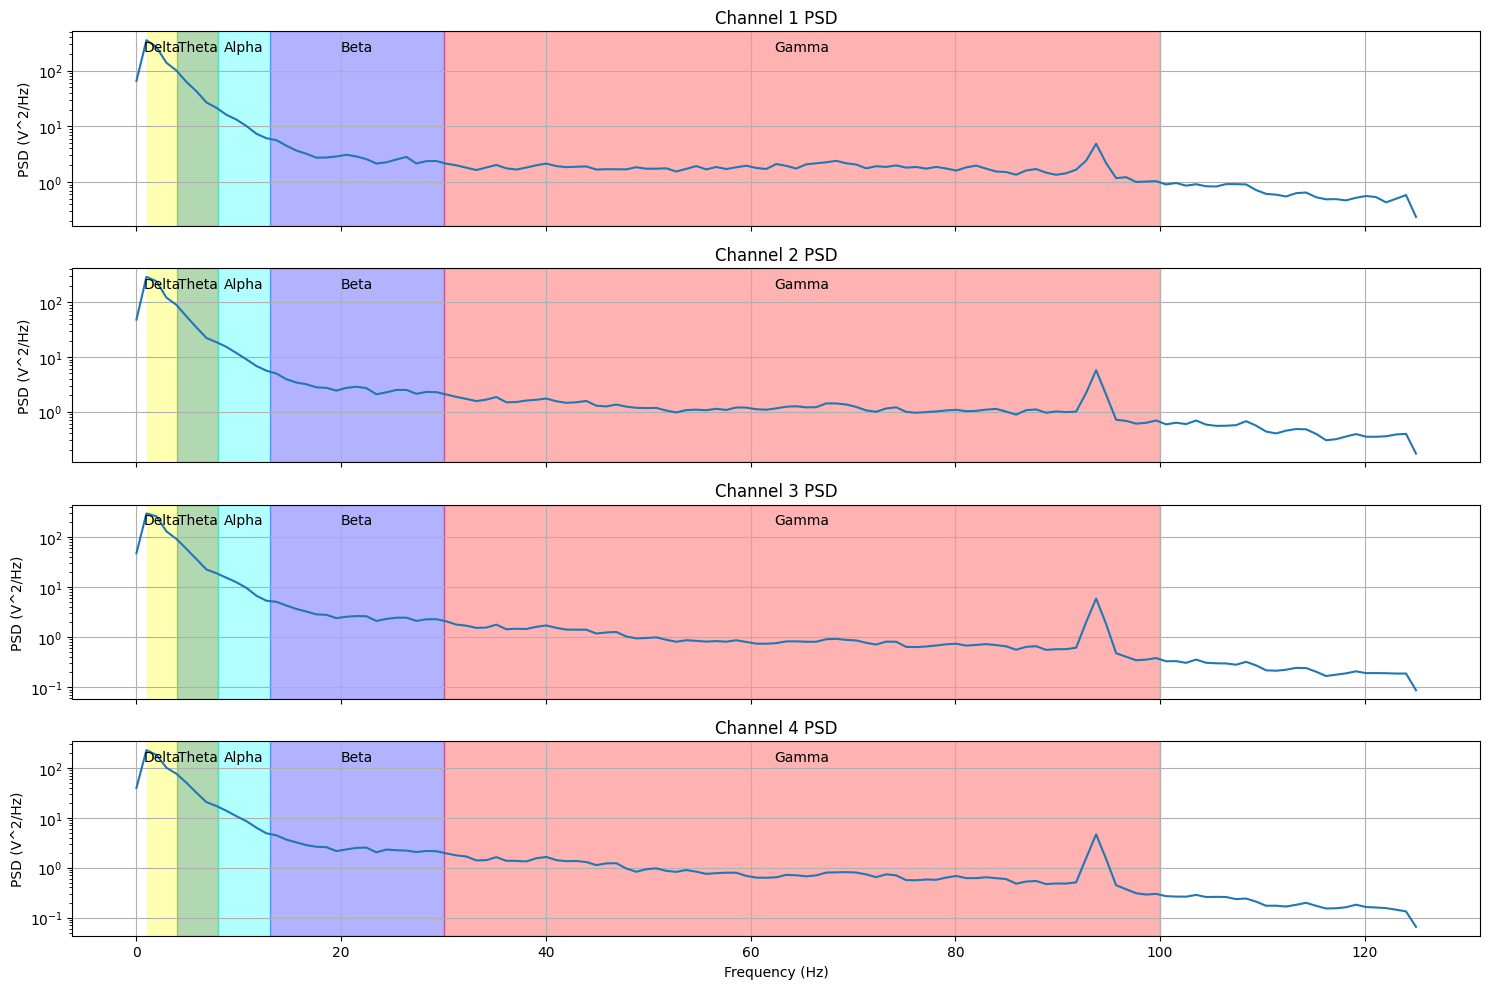

In [8]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Feature extraction

How do we assess quantitatively the presence of a feature in our EEG signals?    
Using HABSlib, we can ask BrainOS to preprocess the raw EEG signals and apply some feature extraction to it.

We need an existing session (we can also do this analysis online, while streaming the data, but this is the content of a follow-up lesson). We will copy-paste the session_id generated above in the next cell.

### Piping functions
Usually, an analysis implies several steps over the raw data.    
BrainOS allows you to perform a whole series of predefined and parametrizable functions over the data, to filter, remove artifacts, and extract features. And you can do it without taking the output of one function and passing it to another. You can pipe (|) the output of one function into the next.     
In our case, we can:
- **filter** the raw EEG to reject the common powerline interference, at 50Hz (signal.iirnotch)
- **bandpass** the result to retain only frequencies between 1 and 40 Hz (signal.butter)
- **remove artifacts** generated by eye movements or other muscles
- **extract a feature** out the many available (uncomment the one you wish)

In [9]:
from scipy import signal
from datetime import datetime

# parameters for the filtering
b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')

new_session_id, processed_data = hb.process_session_pipe(
    pipeline='/filtering/artifact/alpha',
    params={ 
        # dictionary, the order does not matter, they will be called by key
        "filtering": {
            'a_notch': a_notch.tolist(),
            'b_notch': b_notch.tolist(),
            'sos': sos.tolist(),
        },
        "artifact":{},
        "alpha":{},
    },
    user_id='8d60e8693a9560ee57e8eba3', 
    existing_session_id='669a834dcc485c74bb9511b4', # <<<<<<<<<<<< put here the session_id above
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
    session_type="post-processing test", 
    tags=['Developer']
)
print("this session:", new_session_id)
print("processed_data:", processed_data)


{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-07-19 15:18:34', 'existing_session_id': '669a834dcc485c74bb9511b4', 'session_type': '[On 669a834dcc485c74bb9511b4]: post-processing test', 'session_tags': ['Developer']}
Metadata validation successful!
Session successfully created.
this session: 669a83cccc485c74bb9511be
processed_data: [[4.52483494215033, 3.0159719093958457, 2.693034638035929, 2.8320602917654294, 3.2029868401290367, 4.30067960770348, 3.3769578584537903, 2.906313221530295, 2.9761134287354207, 4.291580284048923, 3.3770481047155356, 3.2280982625549974, 3.0962680689394126, 3.022938877302689, 3.2846558798101086, 4.684979434913663, 3.969809563815604], [3.193158046051848, 2.3280347099473744, 2.772431332039008, 2.901179549205419, 3.524310840221269, 4.236907066274901, 3.337055074767508, 3.639579648388898, 3.2975834351453193, 3.212248888975347, 2.4410597694180183, 2.502343014865394, 2.7149288605037496, 2.617370152500677, 3.4621367908383958, 5.16425956551898, 4.9021265

### Plot it
We can plot the analysis that has been performed by BrainOS. The analysis we required above was `/filtering/artifact/alpha`: `filtering` the signal, removing the `artifact`s, and extracting the `alpha` content over time.     
Above, we plotted our local analysis. Here, we can inspect the measure of alpha content over time. 

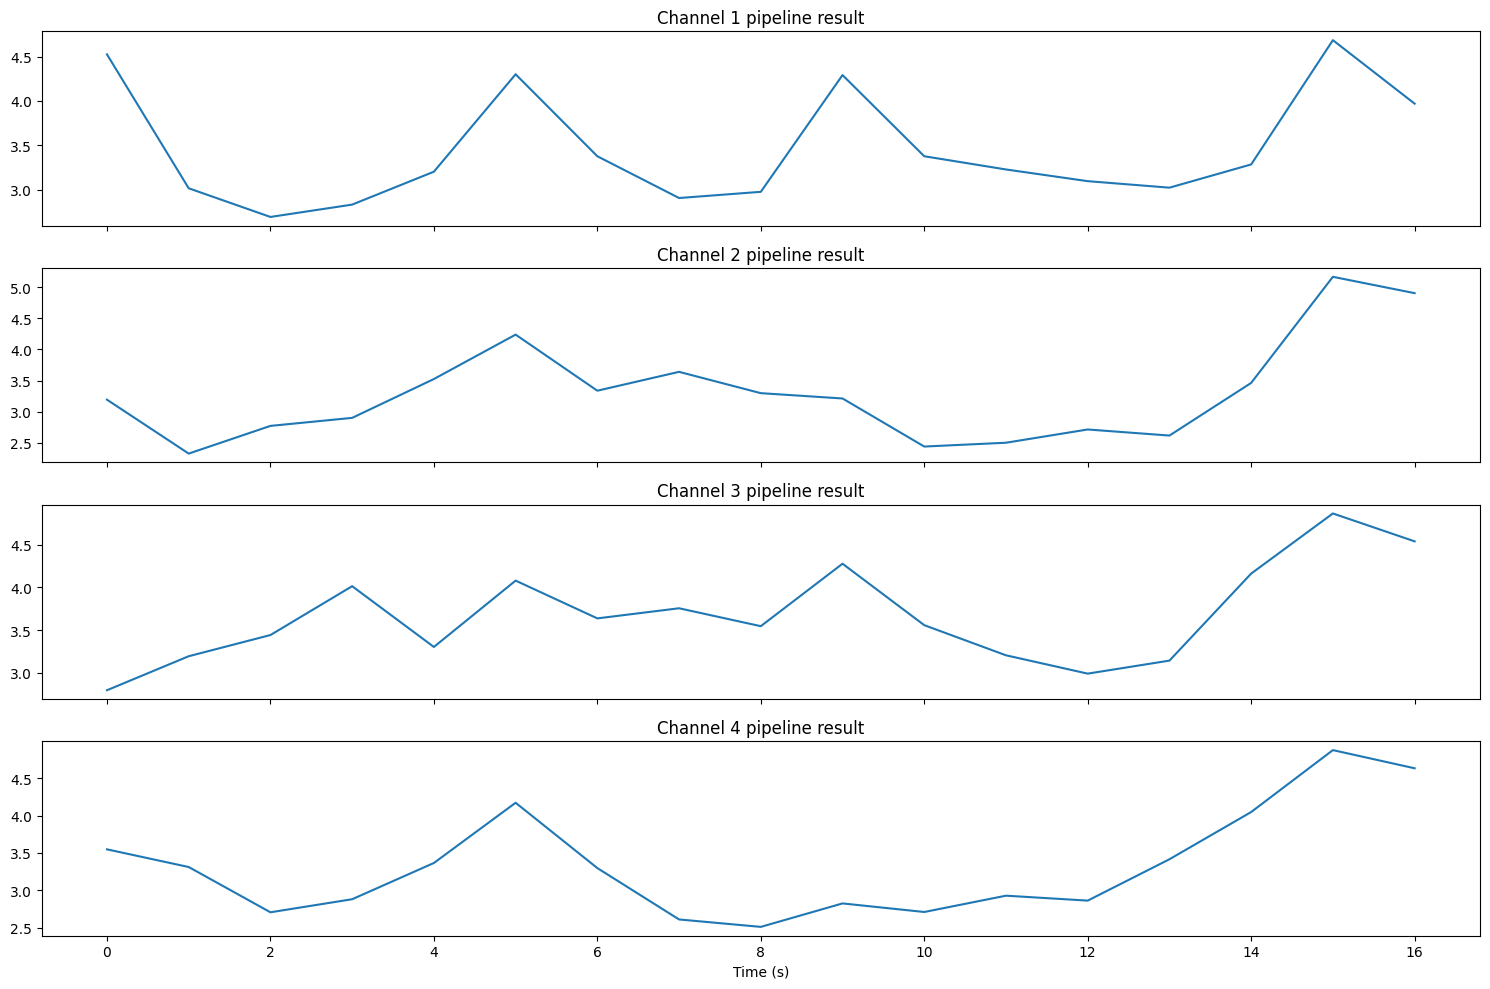

In [10]:
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the pipeline results
    axes[i].plot(processed_data[i])
    axes[i].set_title(f'Channel {i+1} pipeline result')

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Many more features
Besides the filtering and artifact removal (which we are still adding and improving), there are many more functions you can use in the pipeline. Each function in the following list is computed and returned over each channel and for each epoch (unless otherwise specified):
- `mean` : simple mean value
- `std` : standard deviation of the values
- `var` : variance of the values
- `kurtosis` : kurtosis
- `skew` : skewness
- `delta` : delta band absolute amplitude content
- `theta` : theta band absolute amplitude content
- `alpha` : alpha band absolute amplitude content
- `beta` : beta band absolute amplitude content
- `gamma` : gamma band absolute amplitude content
- `zerocrossing` : how many times the signal has crossed the 0
- `hjorthmobility` : mean frequency or the proportion of standard deviation of the power spectrum
- `hjorthcomplexity` : changes in frequency with respect to pure sine waves
- `entropy` : the conditional probability that two sub-sequences remain similar over time
- `fractaldim` : to find long-term statistical dependencies in time series
- `hurst` : the Hurst exponent measuring the long statistical dependencies in the data that do not originate from cycles
- `correlatedim` : the correlation dimension with the Grassberger-Procaccia algorithm
- `selfaffinity` : another function to find long-term statistical dependencies in time series
- `relative` : relative power of a frequency band with respect to others. It requires additional parameters (ex: `{'band': 'alpha'}`)
- `asymmetry` : relative difference in power between channels. It requires additional parameters (ex: `{'band':'alpha', 'channelA':0, 'channelB':2}`)
- `correlation` : correlation in power between channels. It requires additional parameters (ex: `{'band':'alpha', 'channelA':0, 'channelB':2}`)
- `phaselocking` : time correlation between channels. It requires additional parameters (ex: `{'band':'alpha', 'channelA':0, 'channelB':2}`)

You can find more details about these functions on the HABS BrainOS [API Documentation page]().